# Retail Demo




In [3]:
from neo4j import GraphDatabase

# tag::imports[]
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')
pd.set_option('display.float_format', lambda x: '%.3f' % x)
# end::imports[]

In [4]:
bolt_uri = "bolt://localhost:7687"
driver = GraphDatabase.driver(bolt_uri, auth=("neo4j", "letmein"))

print(driver.address)

localhost:7687


### DB Schema

In [3]:
query = """
CALL db.schema.visualization;
"""

with driver.session(database="neo4j") as session:
    #display(session.run(query).consume().counters)
    result = session.run(query)
    results = pd.DataFrame([dict(record) for record in result])
results 

,nodes,relationships
0,"[(name, indexes, constraints), (name, indexes,...","[(), (), (), (), (), (), (), (), (), (), (), ()]"


In [4]:
query = """
CALL apoc.meta.subGraph(
{excludes:['SIMILAR', 'SIMILAR_EMBEDDING', 'SIMILAR_EVERYTHING_EMBEDDING', 'SIMILAR_NODE2VEC_EMBEDDING', 'Similar']});
"""

with driver.session(database="neo4j") as session:
    #display(session.run(query).consume().counters)
    result = session.run(query)
    results = pd.DataFrame([dict(record) for record in result])
results 


,nodes,relationships
0,"[(name, count), (name, count), (name, count), ...","[(count, type, in, out), (count, type, in, out..."


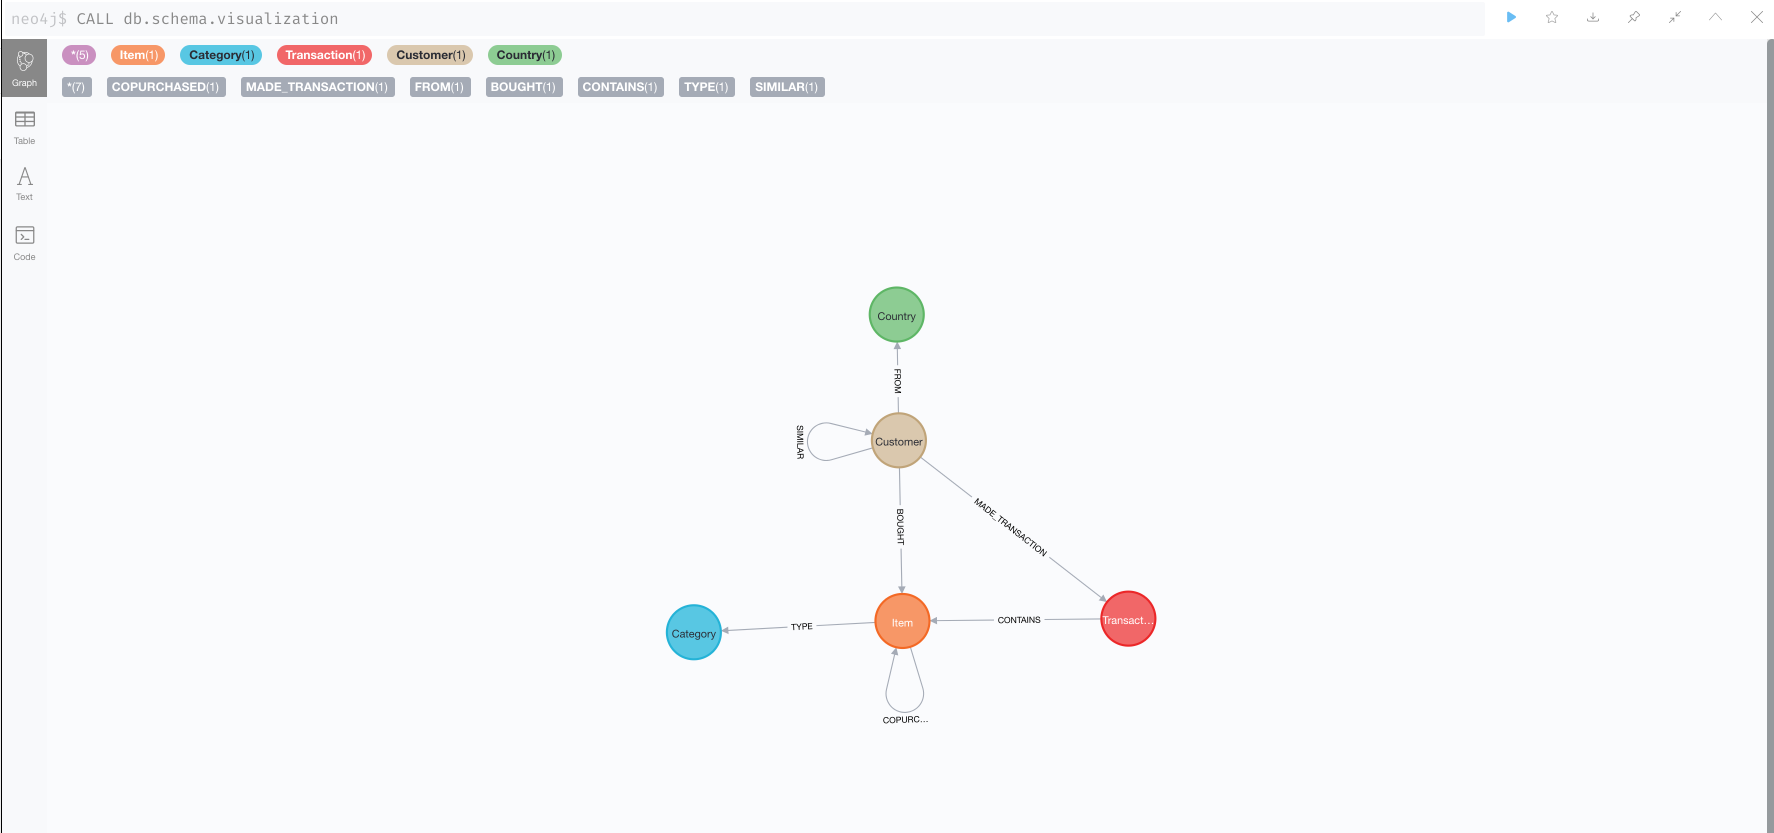

### Clean up Demo

In [15]:
run_queries = """

// Drop all models
CALL gds.beta.model.list()
YIELD modelInfo AS mInfo
WITH mInfo.modelName as savedModel
CALL gds.beta.model.drop(savedModel)
YIELD modelInfo
RETURN modelInfo;

// Drop all graphs
CALL gds.graph.list()
YIELD graphName AS namedGraph
WITH namedGraph
CALL gds.graph.drop(namedGraph)
YIELD graphName
RETURN graphName;

// REMOVE properties
MATCH (i:Item) REMOVE i.embedding;
MATCH (i:Item) REMOVE i.graphsage_embedding;
MATCH (i:Item) REMOVE i.node2vec_embedding;
MATCH (i:Item) REMOVE i.graphsage_embedding_everything;

// Delete extra OWLs
UNWIND ['SEA OWL', 'LAND OWL', 'FIRE OWL', 'FOREST OWL', 'POTATO OWL'] as descr
MATCH (i:Item {Description:descr})
DETACH DELETE i;

// REMOVE extra similarity rels
UNWIND ['SIMILAR_EMBEDDING', 'SIMILAR_GRAPHSAGE_EMBEDDING_MULTIPARTITE','SIMILAR_GRAPHSAGE_EMBEDDING','SIMILAR_GRAPHSAGE_EMBEDDING_KNN', 'SIMILAR_NODE2VEC_EMBEDDING',
      'SIMILAR_EVERYTHING_EMBEDDING', 'Similar', 'SIMILAR'] as rel
MATCH ()-[r]->() WHERE type(r) = rel
DELETE r;   
"""


with driver.session() as session:
    for statement in run_queries.split(';'):
        try:
            session.run(statement.strip())
        except:
            pass

### Load Item Affinity Graph

In [22]:
query = """
CALL gds.graph.create(
  'items',
  {
    Item: {
      label: 'Item',
      properties: {
        price: {
          property: 'avg_price',
          defaultValue: 0.0
        },
        price_scaled: {
         property: 'avg_price_scaled',
         defaultValue: 0
       },
       total_sold: {
         property: 'num_sold',
         defaultValue: 0
       },
       total_sold_scaled: {
         property: 'num_sold_scaled',
         defaultValue: 0
       }
      }
    }
  },
  {
      copurchased: {
        type: 'COPURCHASED',
      orientation: 'UNDIRECTED'
    }
  }
);
"""

with driver.session(database="neo4j") as session:
    #display(session.run(query).consume().counters)
    result = session.run(query)
    results = pd.DataFrame([dict(record) for record in result])
results 

,nodeProjection,relationshipProjection,graphName,nodeCount,relationshipCount,createMillis
0,{'Item': {'properties': {'price_scaled': {'pro...,"{'copurchased': {'orientation': 'UNDIRECTED', ...",items,2864,2430254,479


### **Node2Vec** on items Graph

In [23]:
query = """
CALL gds.alpha.node2vec.stream('items', {
     embeddingDimension: 8, 
     walkLength:16, 
     returnFactor: 1.0,
     inOutFactor:.5,
     concurrency:4});
"""

with driver.session(database="neo4j") as session:
    #display(session.run(query).consume().counters)
    result = session.run(query)
    results = pd.DataFrame([dict(record) for record in result])
results 

,nodeId,embedding
0,12,"[-0.48127540946006775, 0.18506743013858795, 0...."
1,13,"[0.4862574338912964, 0.5233066082000732, 0.576..."
2,14,"[-0.05882648006081581, 0.3673568665981293, 0.2..."
3,15,"[-0.09630923718214035, 0.27312034368515015, 0...."
4,16,"[-0.2119910717010498, 0.3726838231086731, 0.33..."
...,...,...
2859,2871,"[-0.31048938632011414, 0.17524071037769318, 0...."
2860,2872,"[0.7993035912513733, -0.012966255657374859, -0..."
2861,2873,"[-0.12410412728786469, 0.3660004138946533, -0...."
2862,2874,"[-0.3239247798919678, 0.0857771709561348, 0.03..."


### **Node2Vec** write embeddings to graph

In [24]:
query = """
CALL gds.alpha.node2vec.write('items', 
    {
     embeddingDimension: 8, 
     walkLength:16, 
     returnFactor: 1.0,
     inOutFactor:.5,
     writeProperty:'node2vec_embedding',
     concurrency:4
    }
)
"""

with driver.session(database="neo4j") as session:
    #display(session.run(query).consume().counters)
    result = session.run(query)
    results = pd.DataFrame([dict(record) for record in result])
results

,nodeCount,nodePropertiesWritten,createMillis,computeMillis,writeMillis,configuration
0,2864,2864,0,745185,370,"{'initialLearningRate': 0.025, 'writeConcurren..."


### **Calculate Similarity**

In [25]:
query = """
MATCH (i:Item)
 WITH {item:id(i), weights: i.node2vec_embedding} AS itemData
 WITH collect(itemData) AS data
 CALL gds.alpha.similarity.cosine.write({
  data: data,
  skipValue: null,
  topK: 5,
  similarityCutoff:.1,
  writeRelationshipType:'SIMILAR_NODE2VEC_EMBEDDING'
 })
YIELD min, max, mean, stdDev, p25, p50, p75, p90, p95, p99, p999, p100
RETURN min, max, mean, stdDev;
"""

with driver.session(database="neo4j") as session:
    #display(session.run(query).consume().counters)
    result = session.run(query)
    results = pd.DataFrame([dict(record) for record in result])
results

,min,max,mean,stdDev
0,0.726,1.000,0.961,0.050


### **GraphSAGE** model training on items graph

In [26]:
query = """
CALL gds.beta.graphSage.train(
  'items',
  {
    embeddingDimension: 16,
    modelName: 'graphsage_demo',
    featureProperties: ['total_sold_scaled', 'price_scaled'],
    aggregator: 'pool', //aggregating data
    activationFunction: 'sigmoid', //part of the aggregation function
    degreeAsProperty: true, //adding more properties
    epochs: 5, //how many times to traverse the graph during training
    searchDepth:5, //depth of the random walk
    sampleSizes:[25,10], //how many nodes to sample at each layer
    negativeSampleWeight: 10 //used by the loss function
  }
);
"""

with driver.session(database="neo4j") as session:
    #display(session.run(query).consume().counters)
    result = session.run(query)
    results = pd.DataFrame([dict(record) for record in result])
results 


,graphName,graphCreateConfig,modelInfo,configuration,trainMillis
0,items,{},"{'name': 'graphsage_demo', 'type': 'graphSage'}","{'maxIterations': 10, 'negativeSampleWeight': ...",27386


### **Add new data**

In [27]:
query = """
UNWIND ['SEA OWL', 'LAND OWL', 'FIRE OWL', 'FOREST OWL', 'POTATO OWL'] as descr
MATCH (i:Item) where i.Description contains('SPACE OWL') WITH i, descr
CREATE (i2:Item{Description:descr})
CREATE (i) - [:COPURCHASED] -> (i2)
CREATE (i) <- [:COPURCHASED] - (i2);
"""

with driver.session(database="neo4j") as session:
    #display(session.run(query).consume().counters)
    result = session.run(query)
    results = pd.DataFrame([dict(record) for record in result])
results 

""


### **Drop and Load affinity graph again**

In [28]:
query = """
CALL gds.graph.drop('items');
"""

with driver.session(database="neo4j") as session:
    #display(session.run(query).consume().counters)
    result = session.run(query)
    results = pd.DataFrame([dict(record) for record in result])
results

,graphName,database,memoryUsage,sizeInBytes,detailSizeInBytes,nodeProjection,relationshipProjection,nodeQuery,relationshipQuery,nodeCount,relationshipCount,density,creationTime,modificationTime,schema
0,items,neo4j,3063 KiB,3137496,"{'relationships': {'total': 2908528, 'everythi...",{'Item': {'properties': {'price_scaled': {'pro...,"{'copurchased': {'orientation': 'UNDIRECTED', ...",None,None,2864,2430254,0.296,2021-03-25T11:01:57.540516000-04:00,2021-03-25T11:01:59.243571000-04:00,"{'relationships': {'copurchased': {}}, 'nodes'..."


In [29]:
query = """
CALL gds.graph.create(
  'items',
  {
    Item: {
      label: 'Item',
      properties: {
        price: {
          property: 'avg_price',
          defaultValue: 0.0
        },
        price_scaled: {
         property: 'avg_price_scaled',
         defaultValue: 0
       },
       total_sold: {
         property: 'num_sold',
         defaultValue: 0
       },
       total_sold_scaled: {
         property: 'num_sold_scaled',
         defaultValue: 0
       }
      }
    }
  },
  {
    copurchased: {
        type: 'COPURCHASED',
      orientation: 'UNDIRECTED'
    }
  }
);
"""

with driver.session(database="neo4j") as session:
    #display(session.run(query).consume().counters)
    result = session.run(query)
    results = pd.DataFrame([dict(record) for record in result])
results

,nodeProjection,relationshipProjection,graphName,nodeCount,relationshipCount,createMillis
0,{'Item': {'properties': {'price_scaled': {'pro...,"{'copurchased': {'orientation': 'UNDIRECTED', ...",items,2869,2430274,154


### **Apply saved model to predict embeddings**

In [30]:
query = """
CALL gds.beta.graphSage.write(
  'items',
  {
    writeProperty:'graphsage_embedding',
    modelName: 'graphsage_demo'
  });
"""

with driver.session(database="neo4j") as session:
    #display(session.run(query).consume().counters)
    result = session.run(query)
    results = pd.DataFrame([dict(record) for record in result])
results


,nodeCount,nodePropertiesWritten,createMillis,computeMillis,writeMillis,configuration
0,2869,2869,0,1814,95,"{'modelName': 'graphsage_demo', 'writeConcurre..."


### **Check embeddings for newly added data**

In [31]:
query = """
UNWIND ['SEA OWL', 'LAND OWL', 'FIRE OWL', 'FOREST OWL', 'POTATO OWL'] as descr
MATCH (i:Item {Description:descr})
RETURN i.Description, i.graphsage_embedding;
"""

with driver.session(database="neo4j") as session:
    #display(session.run(query).consume().counters)
    result = session.run(query)
    results = pd.DataFrame([dict(record) for record in result])
results


,i.Description,i.graphsage_embedding
0,SEA OWL,"[1.2350249071117245e-08, 7.196271250569227e-11..."
1,LAND OWL,"[1.2350249071117245e-08, 7.196271250569227e-11..."
2,FIRE OWL,"[1.2350249071117245e-08, 7.196271250569227e-11..."
3,FOREST OWL,"[1.2350249071117245e-08, 7.196271250569227e-11..."
4,POTATO OWL,"[1.2350249071117245e-08, 7.196271250569227e-11..."


### **Calculate Similarity embedding**

In [32]:
query = """
 MATCH (i:Item)
 WITH {item:id(i), weights: i.graphsage_embedding} AS itemData
 WITH collect(itemData) AS data
 CALL gds.alpha.similarity.cosine.write({
  data: data,
  skipValue: null,
  topK: 5,
  similarityCutoff:.1,
  writeRelationshipType:'SIMILAR_GRAPHSAGE_EMBEDDING'
 })
YIELD min, max, mean, stdDev, p25, p50, p75, p90, p95, p99, p999, p100
RETURN min, max, mean, stdDev;
"""

with driver.session(database="neo4j") as session:
    #display(session.run(query).consume().counters)
    result = session.run(query)
    results = pd.DataFrame([dict(record) for record in result])
results

,min,max,mean,stdDev
0,1.000,1.000,1.000,0.000


## **GraphSAGE** multipartite graph

In [5]:
query = """
// Drop all graphs
CALL gds.graph.list()
YIELD graphName AS namedGraph
WITH namedGraph
CALL gds.graph.drop(namedGraph)
YIELD graphName
RETURN graphName;
"""

with driver.session(database="neo4j") as session:
    #display(session.run(query).consume().counters)
    result = session.run(query)
    results = pd.DataFrame([dict(record) for record in result])
results

,graphName
0,retail_graph


In [6]:
query = """
CALL gds.graph.create(
  'retail_graph',
  {
    Item: {
      label: 'Item',
      properties: {
        price: {
          property: 'avg_price',
          defaultValue: 0.0
        },
        price_scaled: {
          property: 'avg_price_scaled',
          defaultValue: 0.0
        },
        total_sold: {
         property: 'num_sold',
         defaultValue: 0
       },
       total_sold_scaled: {
         property: 'num_sold_scaled',
         defaultValue: 0
       }
     }
    },
    Transaction: {
      label: 'Transaction',
      properties: {
       EpochTime:{
       	property:'EpochTime',
        defaultValue:0
       }
     }
    }

 
 }, {
    
    CONTAINS: {
      type: 'CONTAINS',
      orientation: 'UNDIRECTED'
    }
});
"""

with driver.session(database="neo4j") as session:
    #display(session.run(query).consume().counters)
    result = session.run(query)
    results = pd.DataFrame([dict(record) for record in result])
results

,nodeProjection,relationshipProjection,graphName,nodeCount,relationshipCount,createMillis
0,{'Transaction': {'properties': {'EpochTime': {...,"{'CONTAINS': {'orientation': 'UNDIRECTED', 'ag...",retail_graph,22718,944668,78


### Train a GraphSAGE model

In [9]:
query = """
// Drop all models, commumity edition, allows one model only
CALL gds.beta.model.list()
YIELD modelInfo AS mInfo
WITH mInfo.modelName as savedModel
CALL gds.beta.model.drop(savedModel)
YIELD modelInfo
RETURN modelInfo;
"""

with driver.session(database="neo4j") as session:
    #display(session.run(query).consume().counters)
    result = session.run(query)
    results = pd.DataFrame([dict(record) for record in result])
results

""


In [10]:
query = """
CALL gds.beta.graphSage.train(
  'retail_graph',
  {
    embeddingDimension: 8,
    modelName: 'graphsage_multipartite_demo',
    //which features should we use? all of them!
    featureProperties: ['price_scaled', 'EpochTime','total_sold_scaled'],
    //specify the projected feature dimension
    projectedFeatureDimension:5, //2 labels + 3 properties
    degreeAsProperty: true, //adding more properties
    epochs: 5, //how many times to traverse the graph during training
    searchDepth:5, //depth of the random walk,
    aggregator: 'mean', //aggregating data
    activationFunction: 'sigmoid', //part of the aggregation function
    sampleSizes:[25,10], //how many nodes to sample at each layer
    negativeSampleWeight: 10 //used by the loss function
  }
);
"""

with driver.session(database="neo4j") as session:
    #display(session.run(query).consume().counters)
    result = session.run(query)
    results = pd.DataFrame([dict(record) for record in result])
results

,graphName,graphCreateConfig,modelInfo,configuration,trainMillis
0,retail_graph,{},"{'name': 'graphsage_multipartite_demo', 'type'...","{'maxIterations': 10, 'negativeSampleWeight': ...",34272


### List model


In [11]:
query = """
CALL gds.beta.model.list()
YIELD modelInfo
RETURN modelInfo;
"""

with driver.session(database="neo4j") as session:
    #display(session.run(query).consume().counters)
    result = session.run(query)
    results = pd.DataFrame([dict(record) for record in result])
results 

,modelInfo
0,"{'modelName': 'graphsage_multipartite_demo', '..."


### What are embeddings again?

In [12]:
query = """
CALL gds.beta.graphSage.stream(
  'retail_graph',
  {
    modelName: 'graphsage_multipartite_demo'
  });
"""

with driver.session(database="neo4j") as session:
    #display(session.run(query).consume().counters)
    result = session.run(query)
    results = pd.DataFrame([dict(record) for record in result])
results 

,nodeId,embedding
0,12,"[0.7051897350912273, 0.00029407691393460594, 2..."
1,13,"[0.7051897350912273, 0.00029407691393460594, 2..."
2,14,"[0.7051897350912273, 0.00029407691393460594, 2..."
3,15,"[0.7051897350912273, 0.00029407691393460594, 2..."
4,16,"[0.7051897350912273, 0.00029407691393460594, 2..."
...,...,...
22713,27135,"[7.825958770671952e-05, 0.00017632029512568828..."
22714,27136,"[7.825958770671952e-05, 0.00017632029512568828..."
22715,27137,"[7.825958770671952e-05, 0.00017632029512568828..."
22716,27138,"[7.825958770671952e-05, 0.00017632029512568828..."


### **Mutate in-memory graph** - Add embeddings to the in-memory graph

In [14]:
query = """
CALL gds.beta.graphSage.mutate(
  'retail_graph',
  {
    modelName: 'graphsage_multipartite_demo',
    mutateProperty:'Embedding'
  });
"""

with driver.session(database="neo4j") as session:
    #display(session.run(query).consume().counters)
    result = session.run(query)
    results = pd.DataFrame([dict(record) for record in result])
results

ClientError: {code: Neo.ClientError.Procedure.ProcedureCallFailed} {message: Failed to invoke procedure `gds.beta.graphSage.mutate`: Caused by: java.lang.IllegalArgumentException: Node property `Embedding` already exists in the in-memory graph.}

### **Write Similarity Property to graph using KNN**

In [16]:
query = """
CALL gds.beta.knn.write('retail_graph', {
    writeRelationshipType: 'SIMILAR_GRAPHSAGE_EMBEDDING_MULTIPARTITE',
    writeProperty: 'score',
    topK: 5,
    randomSeed: 42,
    nodeWeightProperty: 'Embedding'
})
YIELD nodesCompared, relationshipsWritten;
"""

with driver.session(database="neo4j") as session:
    #display(session.run(query).consume().counters)
    result = session.run(query)
    results = pd.DataFrame([dict(record) for record in result])
results

,nodesCompared,relationshipsWritten
0,22718,46242
